## Initial Setup

In [64]:
%pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pickle
import os
import numpy as np
from tqdm import tqdm
import torch

## Importing Pickled Data

In [2]:
# print working directory

data = pickle.load(open("source_pickles/1024d_embeddings_7pts.pkl", "rb"))


# data is a tuple with (patient_name_list, patient_data_list)
# for each patient in patient_data_list, it is a list of 188-898 numpy arrays of (1024, 203) shape

"""merged_data = []

for patient in range(8):
    data_np = data[1][patient][0]
    for i in tqdm(range(1, len(data[1][patient]))):
        data_np = np.concatenate((data_np, data[1][patient][i]), axis=-1)
    merged_data.append(data_np)

for i in range(8):
    merged_data[i] = np.transpose(merged_data[i], (1, 0))


pickle.dump((data[0],merged_data), open("source_pickles/1024d_embeddings_7pts_merged.pkl", "wb"))
    """

'merged_data = []\n\nfor patient in range(8):\n    data_np = data[1][patient][0]\n    for i in tqdm(range(1, len(data[1][patient]))):\n        data_np = np.concatenate((data_np, data[1][patient][i]), axis=-1)\n    merged_data.append(data_np)\n\nfor i in range(8):\n    merged_data[i] = np.transpose(merged_data[i], (1, 0))\n\n\npickle.dump((data[0],merged_data), open("source_pickles/1024d_embeddings_7pts_merged.pkl", "wb"))\n    '

## Model Definition

In [39]:
class TransformerConfig:
    def __init__(self, input_dim, context_size, embedded_dim, hidden_dim, num_heads, num_blocks):
        self.input_dim = input_dim
        self.context_size = context_size # 203 - 1
        self.embedded_dim = embedded_dim
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.hidden_dim = hidden_dim

class TransformerBlock(torch.nn.Module):
    def __init__(self, config):
        super(TransformerBlock, self).__init__()

        self.config = config
        
        self.attention = torch.nn.MultiheadAttention(embed_dim = config.embedded_dim, num_heads = 
        config.num_heads, batch_first = True)
       
        self.positional_embedding = torch.nn.Parameter(0.001 * torch.randn(config.context_size, config.embedded_dim))

        self.norm1 = torch.nn.LayerNorm(config.embedded_dim)
        self.norm2 = torch.nn.LayerNorm(config.embedded_dim)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(config.embedded_dim, config.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(config.hidden_dim, config.embedded_dim)
        )
        
    def forward(self, x):
        # x has the shape (context_size, n, input_dim)
        # pass through self-attention
        x = x + self.positional_embedding
        x = x + self.attention(x, x, x, is_causal = True, attn_mask = torch.nn.Transformer.generate_square_subsequent_mask(self.config.context_size).to("mps")  )[0]
        x = self.norm1(x)
        # pass through mlp
        x = x + self.mlp(x)
        x = self.norm2(x)
        return x

class Transformer(torch.nn.Module):
    def __init__(self, config):

        super(Transformer, self).__init__()

        self.config = config
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(config.input_dim, config.embedded_dim),
        )

        self.blocks = torch.nn.Sequential(*[TransformerBlock(config) for _ in range(config.num_blocks)])

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(config.embedded_dim, config.input_dim),
        )
       
    def forward(self, x):
        # x has the shape (n, input_dim)
        # convert to (nn // context_size, context_size, input_dim)
        x = x.view(-1, self.config.context_size, self.config.input_dim)

        # encode the input
        x = self.encoder(x)

        # pass through transformer blocks
        x = self.blocks(x)
        x = self.decoder(x)
        return x

    def generate_next(self, x):
        # x has the shape (n < context_size, input_dim)
        x = self.encoder(x)

        #token index
        idx = x.shape[0]-1

        #padd with zeros to get to (context_size, input_dim)
        x = torch.cat([x, torch.zeros(self.config.context_size - x.shape[0], x.shape[1]).to(x.device)], dim=0)
        x = self.blocks(x)
        x = self.decoder(x)
        return x[idx]


    
   

                   


## Dataset Definition and Creation

In [10]:

patient_data = data[1]

patient_data_list = []
for patient in patient_data:
    
    patient_frames = []
    for i in tqdm(range(len(patient))):        
        patient_frames.append(torch.from_numpy(patient[i]).reshape(203, 1024))
    patient_tensor = torch.stack(patient_frames, dim = 0)
    patient_data_list.append(patient_tensor)
data_tensor = torch.concat(patient_data_list, dim = 0)
print(data_tensor.shape)

100%|████████████████████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 6619.22it/s]


torch.Size([4744, 203, 1024])


In [59]:
# create dataset
device = torch.device("mps")
data_tensor = data_tensor.to(device)
print(data_tensor.shape)
x_tensor = data_tensor[:, :202, :]
y_tensor = data_tensor[:, 1:, :]
print(x_tensor.shape, y_tensor.shape)

dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)

# valid and train split
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

torch.Size([4744, 203, 1024])
torch.Size([4744, 202, 1024]) torch.Size([4744, 202, 1024])


## Training

In [60]:
config = TransformerConfig(input_dim = 1024, context_size = 202, embedded_dim = 512, hidden_dim = 1024, num_heads = 4, num_blocks = 6)

model = Transformer(config).to("mps")

optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

loss = torch.nn.MSELoss()



model.train()
for epoch in range(100):
    training_losses = []
    for x, y in tqdm(train_loader):
        y_pred = model(x)
        
        l = loss(y_pred, y)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        training_losses.append(l.item())

    print(f"Epoch {epoch}, Loss {np.mean(training_losses)}")

    validation_losses = []
    for x, y in tqdm(valid_dataset):
        y_pred = model(x)
        l = loss(y_pred, y)
        validation_losses.append(l.item())
    print(f"Validation Loss {np.mean(validation_losses)}")


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:14<00:00,  7.97it/s]


Epoch 0, Loss 0.05690729195455543


  0%|                                                                             | 0/949 [00:00<?, ?it/s]/Users/davidzaha/miniconda3/envs/brainhacks25_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([202, 1024])) that is different to the input size (torch.Size([1, 202, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|███████████████████████████████████████████████████████████████████| 949/949 [00:17<00:00, 55.32it/s]


Validation Loss 0.047319454550193533


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.56it/s]


Epoch 1, Loss 0.04860285109206408


100%|███████████████████████████████████████████████████████████████████| 949/949 [00:16<00:00, 56.15it/s]


Validation Loss 0.04986930173381111


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:13<00:00,  8.72it/s]


Epoch 2, Loss 0.049006387090482634


100%|███████████████████████████████████████████████████████████████████| 949/949 [00:17<00:00, 55.48it/s]


Validation Loss 0.047991855541053764


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:17<00:00,  6.66it/s]


Epoch 3, Loss 0.04857628423125804


100%|███████████████████████████████████████████████████████████████████| 949/949 [00:17<00:00, 54.00it/s]


Validation Loss 0.0453091991360685


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.15it/s]


Epoch 4, Loss 0.03307498083645556


100%|███████████████████████████████████████████████████████████████████| 949/949 [00:17<00:00, 55.01it/s]


Validation Loss 0.021097098890342628


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.13it/s]


Epoch 5, Loss 0.019790336004450543


100%|███████████████████████████████████████████████████████████████████| 949/949 [00:17<00:00, 55.09it/s]


Validation Loss 0.019270535626176852


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:16<00:00,  7.42it/s]


Epoch 6, Loss 0.018611099868386733


100%|███████████████████████████████████████████████████████████████████| 949/949 [00:17<00:00, 55.40it/s]


Validation Loss 0.018521143449323194


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.50it/s]


Epoch 7, Loss 0.01802734495336268


100%|███████████████████████████████████████████████████████████████████| 949/949 [00:17<00:00, 55.47it/s]


Validation Loss 0.018086698342966518


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.72it/s]


Epoch 8, Loss 0.01778387400407751


100%|███████████████████████████████████████████████████████████████████| 949/949 [00:16<00:00, 56.01it/s]


Validation Loss 0.017947224007077413


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.85it/s]


Epoch 9, Loss 0.017632571761222446


100%|███████████████████████████████████████████████████████████████████| 949/949 [00:17<00:00, 54.47it/s]


Validation Loss 0.017853757247791965


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.69it/s]


Epoch 10, Loss 0.017577318850309907


100%|███████████████████████████████████████████████████████████████████| 949/949 [00:17<00:00, 53.93it/s]


Validation Loss 0.017666234367883307


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.79it/s]


Epoch 11, Loss 0.017490836729084244


100%|███████████████████████████████████████████████████████████████████| 949/949 [00:16<00:00, 55.97it/s]


Validation Loss 0.017653377365528973


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.92it/s]


Epoch 12, Loss 0.017466307335979297


100%|███████████████████████████████████████████████████████████████████| 949/949 [00:17<00:00, 54.31it/s]


Validation Loss 0.01768831889860497


100%|███████████████████████████████████████████████████████████████████| 119/119 [00:15<00:00,  7.78it/s]


Epoch 13, Loss 0.017431501792195964


100%|███████████████████████████████████████████████████████████████████| 949/949 [00:17<00:00, 54.93it/s]


Validation Loss 0.017607003804669178


 94%|███████████████████████████████████████████████████████████████    | 112/119 [00:14<00:00,  7.83it/s]


KeyboardInterrupt: 

In [50]:
#save the model
torch.save(model.state_dict(), "model.pth")

In [ ]:
#plot the loss function
import matplotlib.pyplot as plt
plt.plot(training_losses)

## Trajectory Plotting

Combined data shape: (38164, 1024)


/Users/davidzaha/miniconda3/envs/brainhacks25_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/davidzaha/miniconda3/envs/brainhacks25_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/5f/vlrq37bj7cg58p99qhr_npcc0000gn/T/ipykernel_23124/3780915056.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], s=2, cmap='Spectral', alpha=0.6)


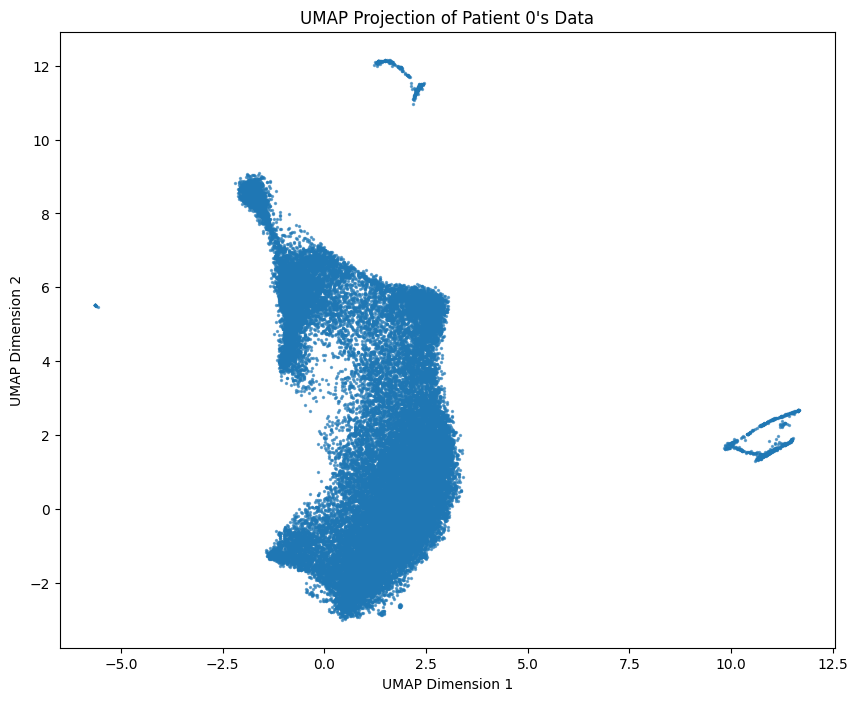

In [16]:
import numpy as np
import umap
import matplotlib.pyplot as plt


# Assuming patient_0_data is a list of 200 numpy arrays with shape (1024, 203)
# Example: patient_0_data = [np.random.rand(1024, 203) for _ in range(200)]
patient_0_data = data[1][0]  # Replace with actual data

# Step 1: Combine all 200 arrays into a single array of shape (x, 1024)
combined_data = np.concatenate([arr.T for arr in patient_0_data], axis=0)  # Transpose arrays to (203, 1024) before concatenating
print(f"Combined data shape: {combined_data.shape}")  # Should be (40600, 1024)

# Step 2: Apply UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(combined_data)


# Step 3: Plot the UMAP
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, cmap='Spectral', alpha=0.6)
plt.title("UMAP Projection of Patient 0's Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

In [61]:
model = Transformer(config).to("mps")
model.load_state_dict(torch.load("model.pth"))

/var/folders/5f/vlrq37bj7cg58p99qhr_npcc0000gn/T/ipykernel_23124/3453702297.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth")

<All keys matched successfully>

/Users/davidzaha/miniconda3/envs/brainhacks25_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


tensor([-0.0133, -0.0280,  0.0111,  ..., -0.0755, -0.0593, -0.0700],
       device='mps:0', grad_fn=<SelectBackward0>)
tensor([-0.0358, -0.0431, -0.0207,  ..., -0.0174,  0.0056, -0.0053],
       device='mps:0', grad_fn=<SelectBackward0>)
tensor([-0.0343, -0.0447, -0.0121,  ...,  0.0017,  0.0509,  0.0188],
       device='mps:0', grad_fn=<SelectBackward0>)
tensor([0.0112, 0.0101, 0.0368,  ..., 0.0266, 0.0241, 0.0239], device='mps:0',
       grad_fn=<SelectBackward0>)
tensor([-0.0069, -0.0193,  0.0185,  ...,  0.2066,  0.2296,  0.2062],
       device='mps:0', grad_fn=<SelectBackward0>)
tensor([0.0740, 0.0711, 0.1080,  ..., 0.0974, 0.1126, 0.1060], device='mps:0',
       grad_fn=<SelectBackward0>)
tensor([ 0.0483,  0.0245,  0.0676,  ..., -0.0682, -0.0467, -0.0324],
       device='mps:0', grad_fn=<SelectBackward0>)
tensor([-0.0287, -0.0335, -0.0049,  ..., -0.0166,  0.0118, -0.0060],
       device='mps:0', grad_fn=<SelectBackward0>)
tensor([ 0.0181, -0.0043,  0.0143,  ...,  0.1219,  0.1460,  

/Users/davidzaha/miniconda3/envs/brainhacks25_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/5f/vlrq37bj7cg58p99qhr_npcc0000gn/T/ipykernel_23124/1475269478.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], s=2, cmap='Spectral', alpha=0.6)


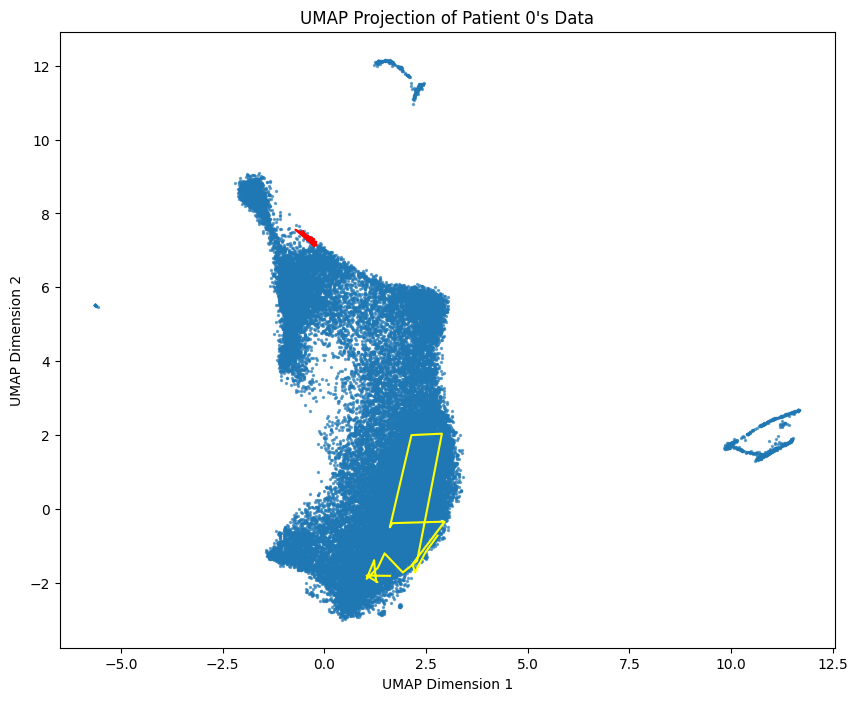

In [62]:
model.eval()
# plot patient 0 file
start = 150
num = 20
patient0_file = data[1][0][0].T


patient0_file = patient0_file[start:start+num, :]
file_embedding = reducer.transform(patient0_file)


#test model
x_tensor = torch.from_numpy(data[1][0][0].T).to(device)[:202, :]
predicted_tensors = []
for i in range(num):
    pred = model.generate_next(x_tensor[:start+i, :])
    #x_tensor[start+i, :] = pred
    predicted_tensors.append(pred)
    print(pred)

predicted_tensors = torch.stack(predicted_tensors, dim = 0).cpu().detach().numpy()
print(f"This is the shape {predicted_tensors.shape}")

pred_embedding = reducer.transform(predicted_tensors)

plt.figure(figsize=(10, 8))
plt.plot(file_embedding[:, 0], file_embedding[:, 1], color= "yellow")
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, cmap='Spectral', alpha=0.6)
plt.plot(pred_embedding[:, 0], pred_embedding[:, 1], color = "red")
plt.title("UMAP Projection of Patient 0's Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()




tensor([[-0.0372, -0.0319, -0.0101,  ...,  0.0556,  0.0951,  0.0944],
        [ 0.0066,  0.0306,  0.0414,  ...,  0.0852,  0.1385,  0.1263],
        [ 0.0027,  0.0126,  0.0477,  ..., -0.0063,  0.0257,  0.0025],
        ...,
        [ 0.0244,  0.0378,  0.0452,  ..., -0.0068,  0.0113, -0.0073],
        [-0.0085, -0.0239, -0.0016,  ..., -0.0608, -0.0290, -0.0427],
        [-0.0704, -0.0938, -0.0655,  ...,  0.0629,  0.0856,  0.0665]],
       device='mps:0', grad_fn=<ViewBackward0>)


/Users/davidzaha/miniconda3/envs/brainhacks25_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


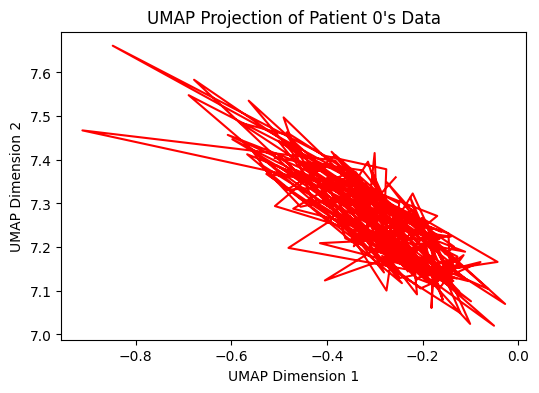

In [52]:
model.eval()
x_tensor = torch.from_numpy(data[1][0][0].T).to(device)[:202, :]

pred = model.forward(x_tensor).view(-1, 1024)
print(pred)

pred_embedding = reducer.transform(pred.cpu().detach().numpy())

plt.figure(figsize=(6, 4))

plt.plot(pred_embedding[:, 0], pred_embedding[:, 1], color = "red")
plt.title("UMAP Projection of Patient 0's Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


In [47]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 9874944


In [58]:
print(pred_embedding.shape)
file_embedding

(20, 2)


array([[ 1.6162596 , -1.8158128 ],
       [ 1.0411861 , -1.8095977 ],
       [ 1.3072691 , -1.9865534 ],
       [ 1.2768323 , -1.9710952 ],
       [ 1.2399248 , -1.6317471 ],
       [ 1.2261488 , -1.3907399 ],
       [ 1.0406216 , -1.8965462 ],
       [ 1.317262  , -1.5932646 ],
       [ 1.4809136 , -1.2076705 ],
       [ 1.9303653 , -1.7249812 ],
       [ 2.2805061 , -1.4125103 ],
       [ 2.8896003 ,  2.0344281 ],
       [ 2.1415265 ,  1.9956622 ],
       [ 1.6102008 , -0.5001872 ],
       [ 1.6741998 , -0.3886179 ],
       [ 2.9576423 , -0.34819472],
       [ 2.167557  , -1.5003375 ],
       [ 2.226762  , -1.7254958 ],
       [ 2.491728  , -1.1683595 ],
       [ 2.779433  , -0.7302109 ]], dtype=float32)